In [2]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
SS_VER='SS_VER_1_1'

In [3]:
%run "Setup_Scripts/Setup_Generic.ipynb"

(ChipWhisperer Other WARNING|File __init__.py:69) ChipWhisperer update available! See https://chipwhisperer.readthedocs.io/en/latest/installing.html for updating instructions
(ChipWhisperer NAEUSB WARNING|File naeusb.py:699) Your firmware (0.30) is outdated - latest is 0.62See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍


## Dummy
Dummy function in blowfish.c

In [4]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-blowfish
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$3 -j
#make clean

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-blowfish'
SS_VER set to SS_VER_1_1
rm -f -- simpleserial-blowfish-CWLITEARM.hex
make[1]: '.dep' is up to date.
rm -f -- simpleserial-blowfish-CWLITEARM.eep
rm -f -- simpleserial-blowfish-CWLITEARM.cof
rm -f -- simpleserial-blowfish-CWLITEARM.elf
rm -f -- simpleserial-blowfish-CWLITEARM.map
rm -f -- simpleserial-blowfish-CWLITEARM.sym
rm -f -- simpleserial-blowfish-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-blowfish.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-blowfish.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-blowfish.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
make[1]: Leaving directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmwar

simpleserial-blowfish.c: In function 'get_pt':
simpleserial-blowfish.c:50:10: warning: pointer targets in passing argument 1 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
          ^~~~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
        ^~~~~~~
simpleserial-blowfish.c:50:16: warning: pointer targets in passing argument 2 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
                ^~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'const char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
     

.
Linking: simpleserial-blowfish-CWLITEARM.elf
arm-none-eabi-gcc -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWLITEARM/simpleserial-blowfish.o -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto/ -std=gnu99  -MMD -MP -MF .dep/simpleserial-blowfish-CWLITEARM.elf.d objdir-CWLITEARM/simpleserial-blowfish.o objdir-CWLITEARM/simpleserial.o objdir-CWLITEARM/stm32f3_hal.o objdir-CWLITEARM/stm32f3_hal_lowlevel.o objdir-CWLITEARM/stm32f3_sysmem.o objdir-CWLITEARM/stm32f3_startup.o --output simpleserial-blowfish-CWLITEARM.elf --specs=nano.specs -

In [5]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-blowfish/simpleserial-blowfish-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 20287 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 20287 bytes


In [6]:
NO_OF_PLAINTEXTS = 50

In [7]:
import random
import string

plaintexts = []
plaintexts = [[random.randint(0, 255) for _ in range(8)] for _ in range(NO_OF_PLAINTEXTS)]

In [8]:
scope.adc.samples = 4200

In [9]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array = []
textin_array = []

# target.set_key(key)
for i in trange(NO_OF_PLAINTEXTS, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(plaintexts[i]))
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 8)
    
    trace_array.append(scope.get_last_trace())

trace_array = np.array(trace_array)

Capturing traces:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


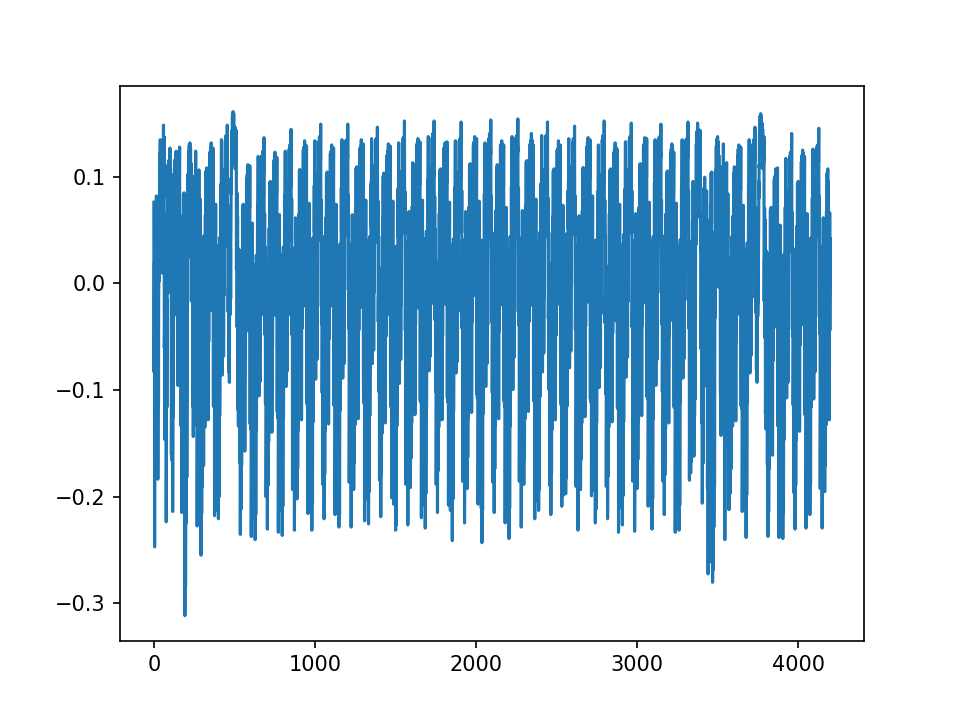

In [10]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array[0])
plt.show()

## Orginal
Orginal blowfish.c code

In [11]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET" "$SS_VER"
cd ../hardware/victims/firmware/simpleserial-blowfish
make PLATFORM=$1 CRYPTO_TARGET=NONE SS_VER=$3 -j
#make clean

SS_VER set to SS_VER_1_1
make clean_objs .dep 
make[1]: Entering directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmware/simpleserial-blowfish'
SS_VER set to SS_VER_1_1
rm -f -- simpleserial-blowfish-CWLITEARM.hex
make[1]: '.dep' is up to date.
rm -f -- simpleserial-blowfish-CWLITEARM.eep
rm -f -- simpleserial-blowfish-CWLITEARM.cof
rm -f -- simpleserial-blowfish-CWLITEARM.elf
rm -f -- simpleserial-blowfish-CWLITEARM.map
rm -f -- simpleserial-blowfish-CWLITEARM.sym
rm -f -- simpleserial-blowfish-CWLITEARM.lss
rm -f -- objdir-CWLITEARM/*.o
rm -f -- objdir-CWLITEARM/*.lst
rm -f -- simpleserial-blowfish.s simpleserial.s stm32f3_hal.s stm32f3_hal_lowlevel.s stm32f3_sysmem.s
rm -f -- simpleserial-blowfish.d simpleserial.d stm32f3_hal.d stm32f3_hal_lowlevel.d stm32f3_sysmem.d
rm -f -- simpleserial-blowfish.i simpleserial.i stm32f3_hal.i stm32f3_hal_lowlevel.i stm32f3_sysmem.i
make[1]: Leaving directory '/home/vagrant/work/projects/chipwhisperer/hardware/victims/firmwar

simpleserial-blowfish.c: In function 'get_pt':
simpleserial-blowfish.c:50:10: warning: pointer targets in passing argument 1 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
          ^~~~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
        ^~~~~~~
simpleserial-blowfish.c:50:16: warning: pointer targets in passing argument 2 of 'strncpy' differ in signedness [-Wpointer-sign]
  strncpy(data, pt, sizeof(data));
                ^~
In file included from blowfish.c:2,
                 from simpleserial-blowfish.c:24:
/usr/include/newlib/string.h:44:8: note: expected 'const char * restrict' but argument is of type 'uint8_t *' {aka 'unsigned char *'}
 char  *strncpy (char *__restrict, const char *__restrict, size_t);
     

+--------------------------------------------------------
.
Linking: simpleserial-blowfish-CWLITEARM.elf
arm-none-eabi-gcc -mcpu=cortex-m4 -I. -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -gdwarf-2 -DSS_VER=SS_VER_1_1 -DSTM32F303xC -DSTM32F3 -DSTM32 -DDEBUG -DHAL_TYPE=HAL_stm32f3 -DPLATFORM=CWLITEARM -DF_CPU=7372800UL -DSS_VER_2_0=2 -DSS_VER_2_1=3 -DSS_VER_1_1=1 -DSS_VER_1_0=0 -Os -funsigned-char -funsigned-bitfields -fshort-enums -Wall -Wstrict-prototypes -Wa,-adhlns=objdir-CWLITEARM/simpleserial-blowfish.o -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././crypto/ -std=gnu99  -MMD -MP -MF .dep/simpleserial-blowfish-CWLITEARM.elf.d objdir-CWLITEARM/simpleserial-blowfish.o objdir-CWLITEARM/simpleserial.o objdir-CWLITEARM/stm32f3_hal.o objdir-CWLITEARM/stm32f3_hal_lowlevel.o objdir-CWLITEARM/stm32f3_sysmem.o objdir-CWLITEARM/stm32f3_startup.o --outpu

In [12]:
cw.program_target(scope, prog, "../hardware/victims/firmware/simpleserial-blowfish/simpleserial-blowfish-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 12851 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 12851 bytes


In [13]:
from tqdm.notebook import trange
import numpy as np
import time

ktp = cw.ktp.Basic()
trace_array_orginal = []

# target.set_key(key)
for i in trange(NO_OF_PLAINTEXTS, desc='Capturing traces'):
    scope.arm()
    
    target.simpleserial_write('p', bytearray(plaintexts[i]))
    
    ret = scope.capture()
    if ret:
        print("Target timed out!")
        continue
    
    response = target.simpleserial_read('r', 8)
    
    trace_array_orginal.append(scope.get_last_trace())

trace_array_orginal = np.array(trace_array_orginal)

Capturing traces:   0%|          | 0/50 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


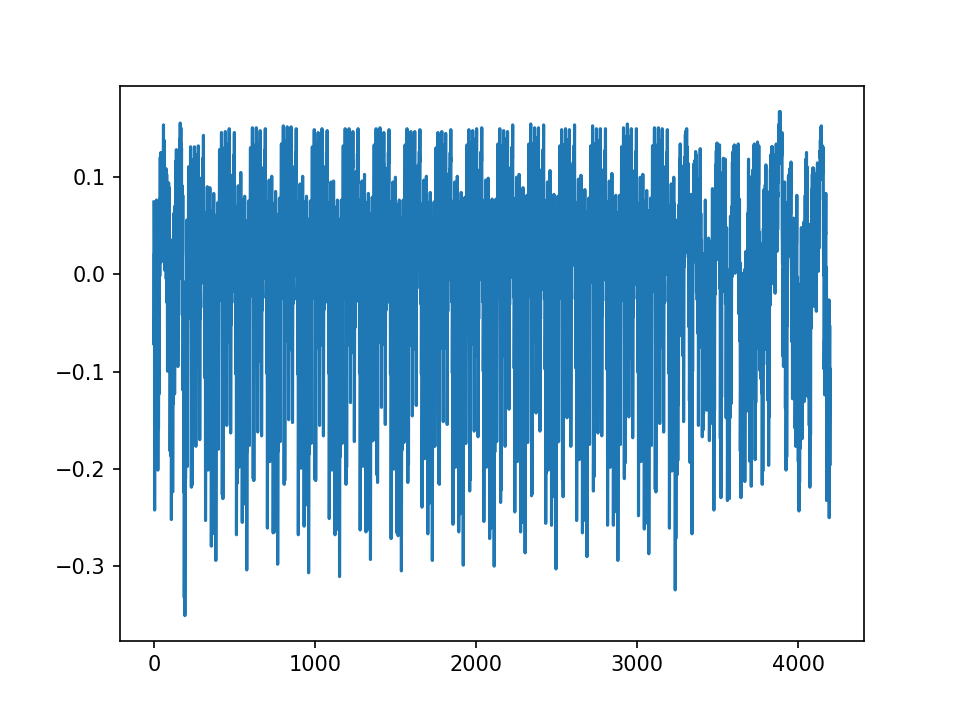

In [14]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array_orginal[0])
plt.show()

<IPython.core.display.Javascript object>


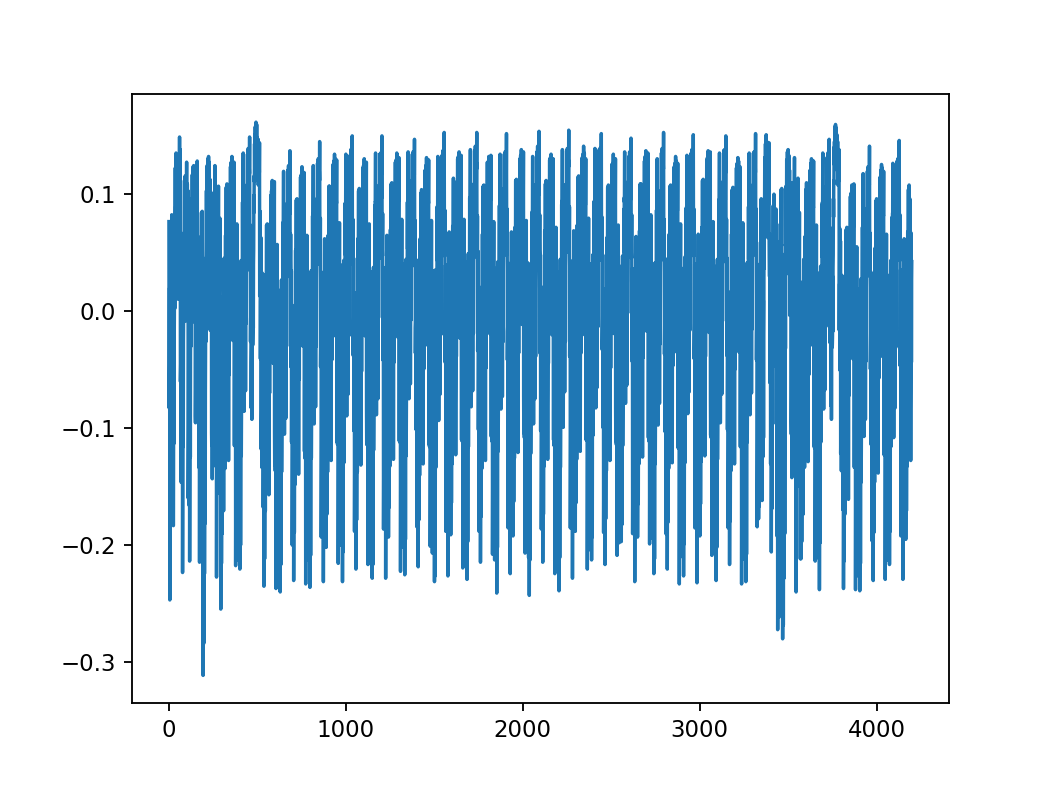

In [24]:
# Dummy code
%matplotlib notebook
import matplotlib.pylab as plt

plt.plot(trace_array[0])
plt.show()

## T-Test

In [23]:
from scipy import stats

for i in range(NO_OF_PLAINTEXTS):
    print(stats.ttest_ind(trace_array[i], trace_array_orginal[i], equal_var = False))
    print(np.var(trace_array[i]), np.var(trace_array_orginal[i]))

Ttest_indResult(statistic=-0.23875825925570057, pvalue=0.8112988650476417)
0.008688849712499416 0.008889685272035146
Ttest_indResult(statistic=-0.034225508672064905, pvalue=0.9726981392915687)
0.008579311630352825 0.008978910893755975
Ttest_indResult(statistic=-0.046601340513015885, pvalue=0.9628320720655901)
0.008623477698778078 0.008948404164865715
Ttest_indResult(statistic=-0.0724619768327223, pvalue=0.942235990266783)
0.008597910609861622 0.00894517123677563
Ttest_indResult(statistic=-0.03160731734599524, pvalue=0.9747859593130825)
0.00854433974306059 0.008891049399992235
Ttest_indResult(statistic=0.004555768525829398, pvalue=0.9963651434583443)
0.008572478212412792 0.008927764155372742
Ttest_indResult(statistic=-0.12730333543158398, pvalue=0.8987033696752014)
0.008528645970870039 0.008886116293768764
Ttest_indResult(statistic=-0.12113332869857943, pvalue=0.9035883312719851)
0.00840451593847772 0.008880510649172899
Ttest_indResult(statistic=0.029536117054798923, pvalue=0.9764377164

In [ ]:
#disconnect
scope.dis()
target.dis()